## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Compute the camera calibration matrix and distortion coefficients

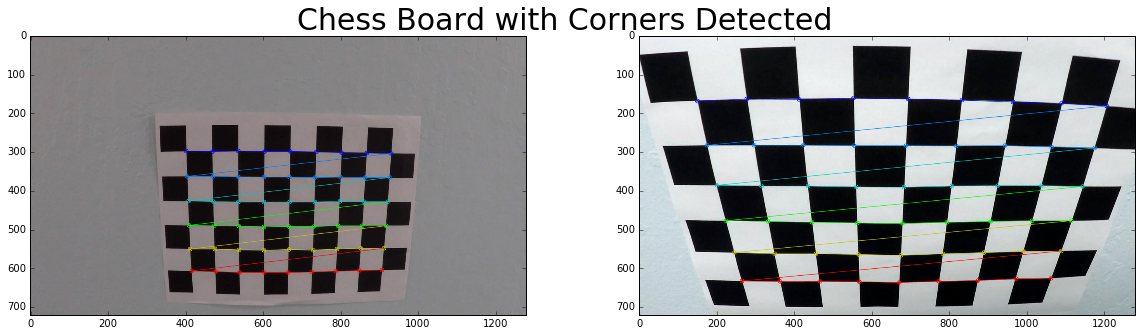

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

class Calibration(object):
    def __init__(self, images, nx = 9, ny = 6):
        self.nx = nx
        self.ny = ny

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((self.ny*self.nx,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:self.nx,0:self.ny].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        self.imagelist = []

        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            #Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)
                
                img = cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                self.imagelist.append(img)
 
    def viewImage(self):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
        f.suptitle('Chess Board with Corners Detected', fontsize=30)
        ax1.imshow(self.imagelist[7])
        ax2.imshow(self.imagelist[10])
        
    def calibrate(self, img):
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img.shape[0:2],None,None)
        
    def undistorted(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def perspectiveTransform(self, img, src, dest, reverse = False):
        M = cv2.getPerspectiveTransform(src, dest) if not reverse else \
                cv2.getPerspectiveTransform(dest, src)
            
        return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags = cv2.INTER_LINEAR), M

calibration = Calibration(glob.glob('camera_cal/calibration*.jpg'))
calibration.viewImage()

## Apply a distortion correction to raw images.

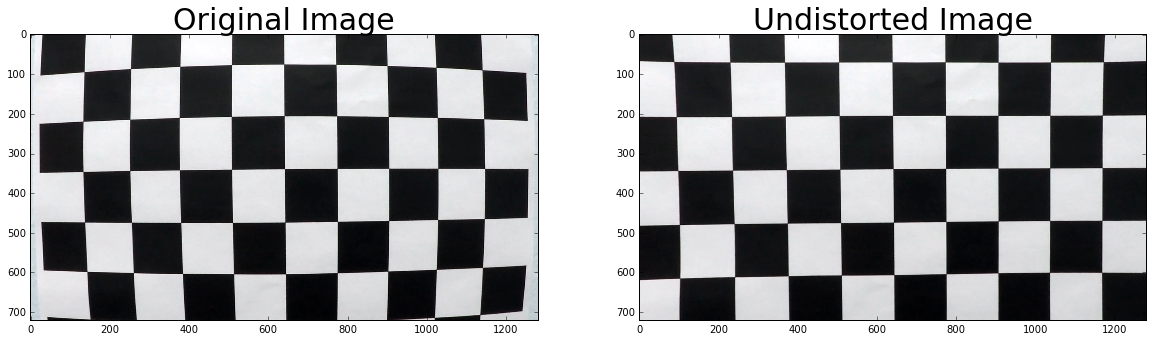

In [2]:
originalImage = cv2.imread('camera_cal/calibration1.jpg')
calibration.calibrate(originalImage)
undistorted = calibration.undistorted(originalImage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(originalImage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)


## example of the Lane image after applying distortion correction

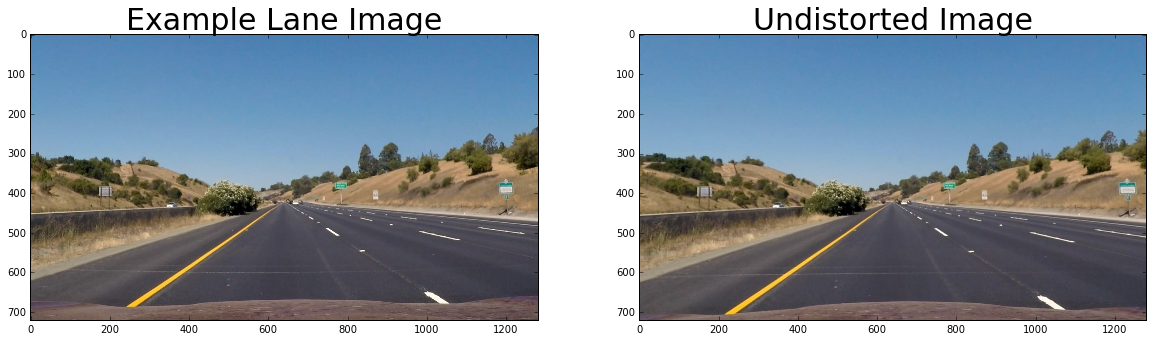

In [3]:
straightline = plt.imread('test_images/straight_lines1.jpg')
undistortedStraightline = calibration.undistorted(straightline)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(straightline)
ax1.set_title('Example Lane Image', fontsize=30)
ax2.imshow(undistortedStraightline)
ax2.set_title('Undistorted Image', fontsize=30)


## Use color transforms, gradients, etc., to create a thresholded binary image

applying the following operation to form the binary image
* sobel operator x direction
* sobel operator y direction
* L Channel from LUV color space
* B channel from Lab color space
* magnitude gradient
* HLS Color Threshold
* limit the data to region of interest

In [4]:
class BinaryThreshold(object):
    def absSobelThresh(self, gray, orient = 'x', sobelKernel = 3, thresh = (0, 255)):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1 if orient == 'x' else 0, 
                    0 if orient == 'x' else 1, ksize = sobelKernel)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        sbinary = np.zeros_like(scaled_sobel)
        sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        return sbinary
    
    def magThresh(self, gray, sobelKernel=3, thresh=(0, 255)):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobelKernel)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def dirThresh(self, gray, sobelKernel=3, thresh=(0, np.pi/2)):
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1 
    
        return binary_output
    
    def hlsSelect(self, img, thresh=(0,255)):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        sChannel = hls[:,:,2]
        binary_output = np.zeros_like(sChannel)
        binary_output[(sChannel > thresh[0]) & (sChannel <= thresh[1])] = 1
        return binary_output

    def bSelect(self, img, thresh = (145, 200)):
        bChannel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2] 
        binary_output = np.zeros_like(bChannel)
        binary_output[(bChannel > thresh[0]) & (bChannel <= thresh[1])] = 1
        return binary_output
 
    def lSelect(self, img, thresh = (225, 255)):
        lChannel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
        binary_output = np.zeros_like(lChannel)
        binary_output[(lChannel > thresh[0]) & (lChannel <= thresh[1])] = 1
        return binary_output
    
    def roi(self, img):
        left_bottom = (100, img.shape[0])
        right_bottom = (img.shape[1] - 50, img.shape[0])
        corner1 = (600, 400)
        corner2 = (700, 400)
        inner_left = (int(0.5*img.shape[1]) - 100, img.shape[0])
        inner_right = (int(0.5*img.shape[1]) + 100, img.shape[0])
        inner_top = (int(0.5*img.shape[1]), int(0.65*img.shape[0]))
        vertices = np.array([[left_bottom, corner1, corner2, right_bottom, inner_right, inner_top, inner_left]], dtype=np.int32)
        mask = np.zeros_like(img)
        ignoreMaskColor = (255,)*img.shape[2] if len(img.shape) > 2 else 255
        
        cv2.fillPoly(mask, vertices, ignoreMaskColor)
        
        return cv2.bitwise_and(img, mask)
    
    def convert(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        abs_bin = self.absSobelThresh(gray, orient='x', thresh = (50, 255))
        abs_bin_y = self.absSobelThresh(gray, orient='y', thresh = (50, 255))
        mag_bin = self.magThresh(gray, sobelKernel = 3, thresh = (50, 255))
        dir_bin = self.dirThresh(gray, sobelKernel=15, thresh=(0.7, 1.3))
        hls_bin = self.hlsSelect(img, thresh=(170, 255))
        b_bin = self.bSelect(img, thresh = (145, 200))
        l_bin = self.lSelect(img, thresh = (225, 255))
        
        combined = np.zeros_like(dir_bin)
        #combined[(((abs_bin == 1) & (abs_bin_y == 1)) | ((mag_bin == 1) & (dir_bin == 1))) | (hls_bin == 1) | \
                 #(b_bin == 1) | (l_bin ==  1)] = 1
        combined[((abs_bin == 1) & (abs_bin_y == 1)) | (b_bin == 1) | (l_bin == 1)] = 1
        
        return combined    

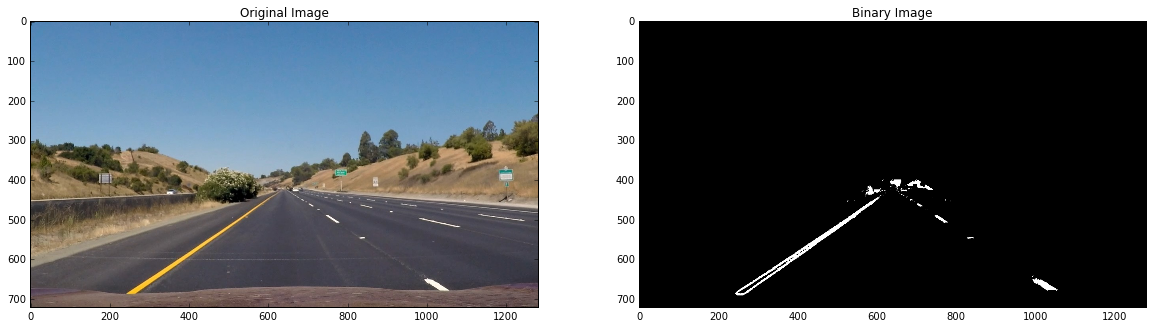

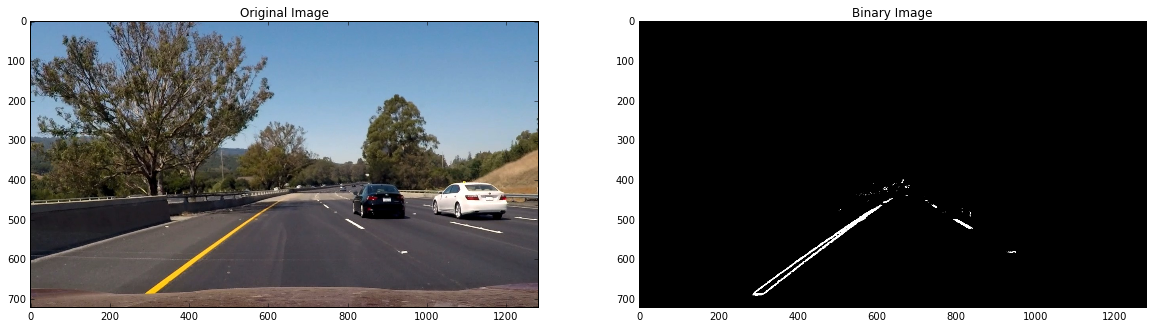

In [5]:
binary = BinaryThreshold()
testfiles = [ 'test_images/straight_lines1.jpg', 'test_images/test6.jpg']
for i in range(len(testfiles)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    img = plt.imread(testfiles[i])
    ax1.imshow(img)
    ax1.set_title('Original Image')
    gray = binary.convert(img)
    ax2.imshow(binary.roi(gray), cmap = 'gray')
    ax2.set_title('Binary Image')


## Apply a perspective transform to rectify binary image ("birds-eye view").

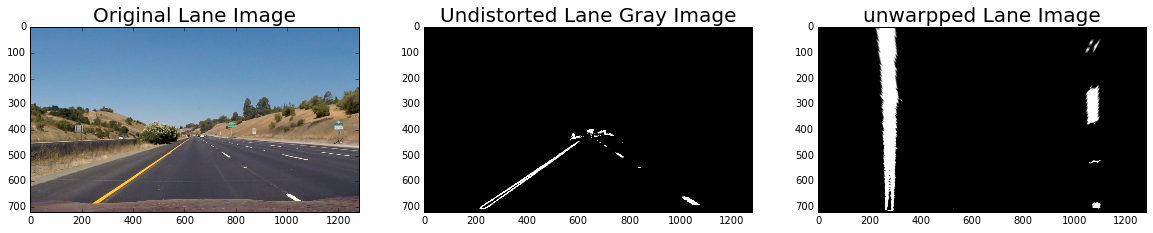

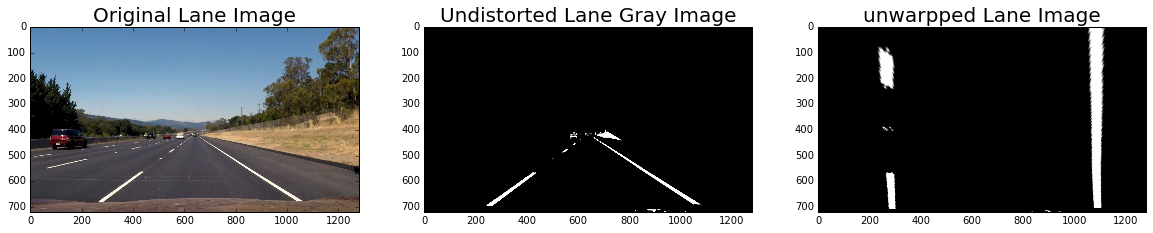

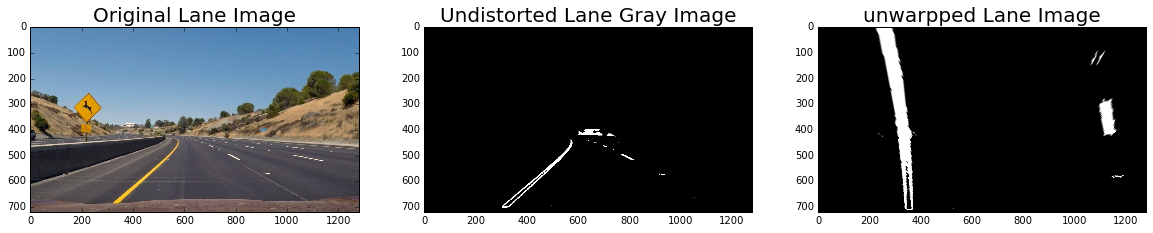

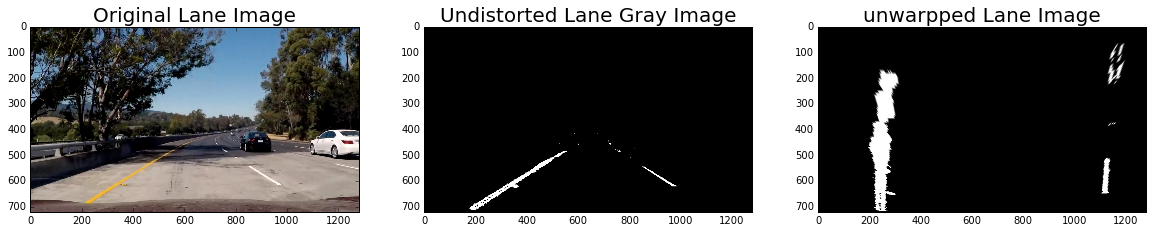

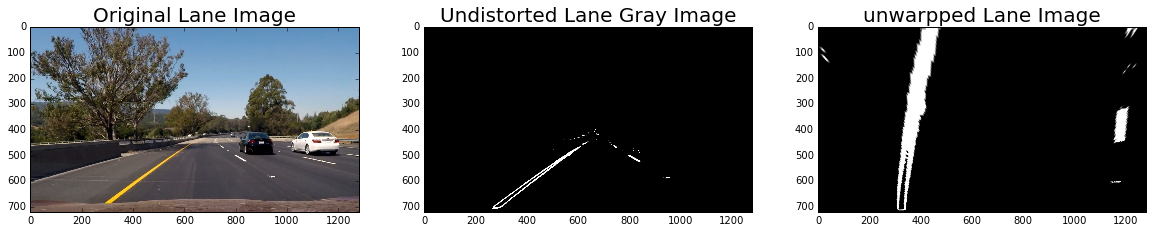

In [6]:
testimages = [ 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg',
               'test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']
src = np.float32([
        [120, 720], [555, 470], [720, 470], [1100, 720]
    ])
dest = np.float32([
        [200, 720], [200, 0], [1080, 0], [1080, 720]
    ])
for testimgpath in testimages:
    testimg = plt.imread(testimgpath)
    undistortedTestImg = calibration.undistorted(testimg)
    gray = binary.convert(undistortedTestImg)
    grayroi = binary.roi(gray)
    unwarped, M = calibration.perspectiveTransform(grayroi, src, dest)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.imshow(testimg)
    ax1.set_title('Original Lane Image', fontsize=20)
    ax2.imshow(grayroi, cmap = 'gray')
    ax2.set_title('Undistorted Lane Gray Image', fontsize=20)
    ax3.imshow(unwarped, cmap = 'gray')
    ax3.set_title('unwarpped Lane Image', fontsize=20)


* Detect lane pixels and fit to find the lane boundary
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.

In [7]:
from collections import deque
from scipy import signal

# line class to extract line information from binary image
class Line(object):
    def __init__(self):
        #number of sliding windows
        self.nwindows = 9
        #set the width of the windows +/- margin
        self.margin = 25
        #set the minimum number of pixels found to recenter window
        self.minpix = 50
        #the previous stored line position
        self.current = None
        #previous stored best fit curve
        self.fit = None
        self.fitted = None
        self.fittedX = None
        self.fitted0 = None
        self.py = None
        self.px = None
        # line detected?
        self.detected = False
        self.radiusOfCurvature = None
        self.ym_per_pix = 30.0/720
        self.xm_per_pix = 3.7/700

    def isDetected(self):
        return self.detected
    
    def getCurrent(self):
        return self.current
    
    def getFit(self):
        return self.fit
    
    def setFit(self, fit):
        self.fit = fit

    def getRadiusOfCurvature(self):
        return self.radiusOfCurvature
    
    def getFitted(self):
        return self.fitted
    
    def getFittedX(self):
        return self.fittedX

    def getFitted0(self):
        return self.fitted0

    def getPy(self):
        return self.py
    
    def calcRadiusOfCurvature(self, px, py):
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(py*self.ym_per_pix, px*self.xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.radiusOfCurvature = ((1 + (2*fit_cr[0]*np.max(py)*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    def doFit(self, px, py, binary_warped):
        # Fit a second order polynomial to each
        if len(px) == 0:
            return None, None, False
        
        self.fit, residual, _, _, _ = np.polyfit(py, px, 2, full = True)
        isgoodfit = residual*1.0/(len(py)*binary_warped.shape[1])
        
        self.fittedX = self.fit[0]*binary_warped.shape[0]**2 \
                        + self.fit[1]*binary_warped.shape[0] + self.fit[2]
        self.fitted0 = self.fit[2]
        self.fitted = self.fit[0]*py**2 + self.fit[1]*py + self.fit[2]
        
        px = np.append(px, self.fittedX)
        px = np.append(px, self.fitted0)
        py = np.append(py, binary_warped.shape[0])
        py = np.append(py, 0)
        sorted = np.argsort(py)
        px = px[sorted]
        py = py[sorted]
        
        self.fit = np.polyfit(py, px, 2)
        self.fittedX = self.fit[0]*binary_warped.shape[0]**2 \
                        + self.fit[1]*binary_warped.shape[0] + self.fit[2]
        self.fitted0 = self.fit[2]
        self.fitted = self.fit[0]*py**2 + self.fit[1]*py + self.fit[2]
        
        self.calcRadiusOfCurvature(px, py)
        
        return px, py, isgoodfit
    
    # fitting lane line starting from last known position
    def incrementalFit(self, binaryimg, nonzerox, nonzeroy):
        lane_inds = ((nonzerox > (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + self.fit[2] - self.margin)) & \
                     (nonzerox < (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + self.fit[2] + self.margin))) 

        # Again, extract line pixel positions
        px = nonzerox[lane_inds]
        py = nonzeroy[lane_inds] 
        
        self.px, self.py, isgoodfit = self.doFit(px, py, binaryimg)
        self.detected = self.px is not None and (np.sum(px) > 0)
        if not self.detected or not isgoodfit:
            return (None, None, None)
        
        return (self.fit, self.fitted, self.py)

    # fitting lane line from scratch
    def fitFromScratch(self, binary_warped, histogram, start, nonzerox, nonzeroy):
        base = np.argmax(histogram) + start
        #peakIdx = signal.find_peaks_cwt(histogram, np.arange(binary_warped.shape[1]*0.025,
                                                           #binary_warped.shape[1]*0.05))
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/self.nwindows)        
        self.current = base
        # Create empty lists to receive lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        isleft = (start == 0)
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = self.current - self.margin
            win_x_high = self.current + self.margin  
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > self.minpix:
                self.current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract line pixel positions
        px = nonzerox[lane_inds]
        py = nonzeroy[lane_inds]  
            
        self.px, self.py, isgoodfit = self.doFit(px, py, binary_warped)
        self.detected = self.px is not None and (np.sum(px) > 0)

        return (self.fit, self.fitted, self.py)

#lane class, which hold left and right line object to hold left/right line information
class Lane(object):
    def __init__(self, calibration, binary, source, destination):
        self.calibration = calibration
        self.binary = binary
        self.source = source
        self.destination = destination
        self.leftLine = Line()
        self.rightLine = Line()
        self.good_left_py = None
        self.good_right_py = None
        self.good_left_fitted = None
        self.good_right_fitted = None
        self.good_left_fit = None
        self.good_right_fit = None
        self.isGoodSeparation = False
        self.leftQueue = deque()
        self.rightQueue = deque()
        self.counter = 0
        self.savedCenter = 0
        self.savedCurvature = 0

    def getLeftFitted(self):
        return self.leftLine.getFitted()
    
    def getRightFitted(self):
        return self.rightLine.getFitted()
    
    def getLeftPy(self):
        return self.leftLine.getPy()
    
    def getRightPy(self):
        return self.rightLine.getPy()

    #used if we already have the lane information from previous calculation
    def incrementalFit(self, binaryimg):
        nonzero = binaryimg.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_fit, left_fitted, left_py = self.leftLine.incrementalFit(binaryimg, nonzerox, nonzeroy)
        right_fit, right_fitted, right_py = self.rightLine.incrementalFit(binaryimg, nonzerox, nonzeroy)

        return (left_fit, right_fit, left_fitted, right_fitted, left_py, right_py)

    def processImage(self, img):
        binary_warped, M = self.unwrap(img)
        return self.fit(binary_warped)

    #saniry check if the separation between left and right lane is reasonable
    #and separation of the lane is not too small
    def hasGoodSeparation(self, left_fit, right_fit, shape): 
        ycoord = [ 0, shape[0]//2, max(shape[0]-1, 0) ]
        ymax = max(ycoord)
        polyleft = np.poly1d(left_fit)
        left_xcoord = polyleft(ycoord)
        polyright = np.poly1d(right_fit)
        right_xcoord = polyright(ycoord)
        res = True
        dist0 = abs(left_xcoord[0]  - right_xcoord[0]) if len(left_xcoord) > 0 else 0
        for i in range(len(left_xcoord)):
            dist = abs(left_xcoord[i] - right_xcoord[i])
            uplimit = dist0 + 200
            downlimit = max(dist0 - 200, 0)
            #do we have good distance between the lane line?
            if (dist <100) or (left_xcoord[i] >= right_xcoord[i]) or \
                (dist > uplimit) or (dist < downlimit) :
            #if (dist < 100) or (left_xcoord[i] >= right_xcoord[i]):
                res = False
                break
            dist0 = dist
        
        self.isGoodSeparation = res
        return res
                          
    def isDetected(self):
        #have we detect the lane line successfully last time?
        return self.leftLine.isDetected() and self.rightLine.isDetected()
    
    def fit(self, binary_warped):
        #check if we can use the result from previous iteration
        if self.isDetected() and self.isGoodSeparation:
            left_fit, right_fit, left_fitted, right_fitted, left_py, right_py = self.incrementalFit(binary_warped)
            if left_fit is not None and right_fit is not None and self.isDetected() and \
                self.hasGoodSeparation(left_fit, right_fit, binary_warped.shape):
                return (left_fit, right_fit, left_fitted, right_fitted, left_py, right_py)

        return self.fitFromScratch(binary_warped)
        
    def fitFromScratch(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        right_fit, right_fitted, right_py = self.rightLine.fitFromScratch(binary_warped,
                                            histogram[midpoint:-100], midpoint, nonzerox, nonzeroy)
        left_fit, left_fitted, left_py = self.leftLine.fitFromScratch(binary_warped, 
                                            histogram[100:midpoint], 100, nonzerox, nonzeroy)

        return (left_fit, right_fit, left_fitted, right_fitted, left_py, right_py)
        
    def unwrap(self, testimg):
        undistortedTestImg = self.calibration.undistorted(testimg)
        gray = self.binary.convert(undistortedTestImg)
        grayroi = self.binary.roi(gray)
        return self.calibration.perspectiveTransform(grayroi, self.source, self.destination)

    #calculate the center of the car relative the the center of the image
    def calcCenter(self, img):
        return abs(img.shape[1]*0.5 - (self.leftLine.getFittedX() + self.rightLine.getFittedX())//2) \
                        * self.leftLine.xm_per_pix

    #calculates the radius of curvature for the lane line
    def getRadiusOfCurvature(self):
        return (self.leftLine.getRadiusOfCurvature() + self.rightLine.getRadiusOfCurvature())//2

    def addFittedLane(self, img):
        undistorted = self.calibration.undistorted(img)
        gray = binary.roi(binary.convert(undistorted))
        binary_warped, M = self.calibration.perspectiveTransform(gray, self.source, self.destination)
        #plt.imsave('test/img' + str(self.counter) + '.jpg', undistorted)
        left_fit, right_fit, left_fitted, right_fitted, left_py, right_py = self.fit(binary_warped)
        if (not self.isDetected() or not self.hasGoodSeparation(left_fit, right_fit, img.shape)) \
            and self.good_left_fitted is not None:
            left_fitted = self.good_left_fitted
            right_fitted = self.good_right_fitted
            left_py = self.good_left_py
            right_py = self.good_right_py
        else:
            #good update, store the updated left/right fit curve
            if len(self.leftQueue) >= 10:
                self.leftQueue.popleft()
            self.leftQueue.append(left_fit)
            if len(self.rightQueue) >= 10:
                self.rightQueue.popleft()
            self.rightQueue.append(right_fit)
            #calculate the mean fitting parameter
            good_left_fit = [0]*len(left_fit)
            leftlen = len(self.leftQueue)
            for fititem in self.leftQueue:
                for i in range(len(good_left_fit)):
                    good_left_fit[i] += fititem[i]*1.0/leftlen
            good_right_fit = [0]*len(right_fit) 
            rightlen = len(self.rightQueue)
            for fititem in self.rightQueue:
                for i in range(len(good_right_fit)):
                    good_right_fit[i] += fititem[i]*1.0/rightlen
            #use the average fitting parameter to recalculate the fitted curve
            left_fitted = good_left_fit[0]*left_py**2 + good_left_fit[1]*left_py + good_left_fit[2]
            right_fitted = good_right_fit[0]*right_py**2 + good_right_fit[1]*right_py + good_right_fit[2]
            
            self.good_left_fitted = left_fitted
            self.good_right_fitted = right_fitted
            self.good_left_py = left_py
            self.good_right_py = right_py
            self.good_left_fit = left_fit
            self.good_right_fit = right_fit
            
        self.leftLine.setFit(self.good_left_fit)
        self.rightLine.setFit(self.good_right_fit)
            
        center = self.calcCenter(img)
        Minv = cv2.getPerspectiveTransform(dest, src)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitted, left_py]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitted, right_py])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        return cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
   
    def processVideo(self, img):
        updated = self.addFittedLane(img)
        center = self.calcCenter(img)
        midpoint = img.shape[1]//2
        cv2.putText(updated, 'vehicle is {:.2f} m {} of the center'.format(center, 
                'left' if (midpoint > center) else 'right'), (100,80), fontFace=16, fontScale=2, color = (255,255,255), thickness=2)
        cv2.putText(updated, 'radius of curvature: {} m'.format(int(self.getRadiusOfCurvature())), (120, 140),
                fontFace=16, fontScale=2, color = (255,255,255), thickness=2)
        return updated

## calculates the radius of curvature, center of the car relative to center of the image and display it in the image

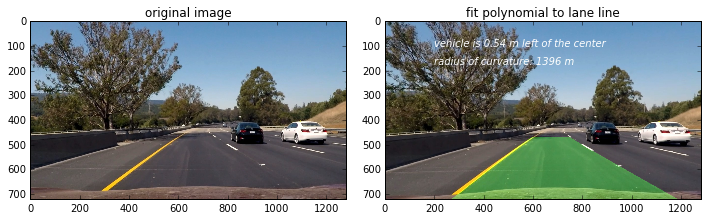

In [8]:
lane = Lane(calibration, binary, src, dest)
img = plt.imread('test_images/test6.jpg')
#img = plt.imread('test/img1.jpg')
updatedImage = lane.addFittedLane(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image')
ax2.imshow(updatedImage)
center = lane.calcCenter(img)
midpoint = img.shape[1]//2
ax2.text(200, 100, 'vehicle is {:.2f} m {} of the center'.format(center, 
        'left' if (midpoint > center) else 'right'), style = 'italic', color = 'white', fontsize = 10)
ax2.text(200, 175, 'radius of curvature: {} m'.format(int(lane.getRadiusOfCurvature())),
        style = 'italic', color = 'white', fontsize = 10)
ax2.set_title('fit polynomial to lane line')


In [ ]:
#Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [9]:
from moviepy.editor import VideoFileClip

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [24]:
lane = Lane(calibration, binary, src, dest)
#clipProject = VideoFileClip('project_video.mp4').subclip(40,49).fl_image(lane.processVideo)
clipProject = VideoFileClip('project_video.mp4').fl_image(lane.processVideo)
clipProject.write_videofile('out_project_video.mp4', audio = False)

  self.nchannels))



[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:20<00:00,  3.93it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 



In [11]:
from IPython.display import HTML
HTML("""
     <video width="640" height="360" controls>
         <source src="{0}">
     </video>
""".format('out_project_video.mp4'))

In [25]:
lane = Lane(calibration, binary, src, dest)
clip1Project = VideoFileClip('challenge_video.mp4').fl_image(lane.processVideo)
clip1Project.write_videofile('out_challenge_video.mp4', audio = False)

  self.nchannels))



[MoviePy] >>>> Building video out_challenge_video.mp4
[MoviePy] Writing video out_challenge_video.mp4


100%|███████████████████████████████████████▉| 484/485 [01:58<00:00,  4.04it/s]WARNING:py.warnings:C:\Anaconda\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:116: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|████████████████████████████████████████| 485/485 [01:58<00:00,  3.99it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_video.mp4 



In [13]:
from IPython.display import HTML
HTML("""
     <video width="640" height="360" controls>
         <source src="{0}">
     </video>
""".format('out_challenge_video.mp4'))

In [26]:
lane = Lane(calibration, binary, src, dest)
clip2Project = VideoFileClip('harder_challenge_video.mp4').fl_image(lane.processVideo)
clip2Project.write_videofile('out_harder_challenge_video.mp4', audio = False)

  self.nchannels))



[MoviePy] >>>> Building video out_harder_challenge_video.mp4
[MoviePy] Writing video out_harder_challenge_video.mp4


100%|█████████████████████████████████████▉| 1199/1200 [05:21<00:00,  3.69it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: out_harder_challenge_video.mp4 



In [15]:
from IPython.display import HTML
HTML("""
     <video width="640" height="360" controls>
         <source src="{0}">
     </video>
""".format('out_harder_challenge_video.mp4'))

##Discussion

The L Channel from the Lab Color Space, is good at picking out the Yellow line. In the Challenge video,
the left lane life is very close to the shade and a lot of time it confuse the system. Using the L channel
helps a lot in processing the image.

when determining if the lane formed is good, it look at the residual from the polyfit, if it is too big, it will reject the line.
Also it will check if the lane form has reasonable distance between left and right lane line.

If the code can not find a good lane from the current image, it will use the last good fit to project the current lane line,
and when it finds a good lane line, it will average it with last 10 good value, to smooth the output. This is to avoid
the lane line drawn on the image jumping around rapidly.

The code has problem with challenge and harder challenge video, and is particular bad on harder challenge.Possibly
i need to have different criteria or filtering when forming the binary threshold, that depends on the darkness level,
illumination level etc, to make it better detect the lane line.